In [55]:
import umap
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import DictionaryLearning

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from contrastive.evaluation.train_multiple_classifiers import compute_auc

In [56]:
# test model
test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/trained_on_HCP_half_2/all/foldlabel/convnet-10/09-21-24_3"
# test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#5"

# UMAP

In [57]:
def get_model_by_quality(labels_df, q=0.5):
    aucs = labels_df.apply(compute_auc, args=[labels_df.label])
    aucs = aucs[aucs.index != 'label']
    model_auc = aucs.quantile(q=q, interpolation='nearest')
    aucs = aucs[aucs == model_auc]
    return(aucs.index[0], model_auc)

In [58]:
def visualize_umaps(model_path, quantiles=[0,0.5,1], thresholds=[0.25,0.5,0.75], show_wrong_class=False, dataset='cingulate_ACCpatterns_1', verbose=False):
    # load the data
    data_df = pd.read_csv(model_path+'/' + dataset + "_embeddings/full_embeddings.csv", index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path + '/' + dataset + "_embeddings/cross_val_predicted_labels.csv", index_col=0)
    prediction_df.sort_index(inplace=True)
    
    if verbose:
        print("Data df:")
        print(data_df[:5])
        print("Prediction df:")
        print(prediction_df[:5])

    # apply umap
    reducer = umap.UMAP()
    visual_embs = reducer.fit_transform(data_df)
    if verbose:
        print("UMAP embeddings")
        print(visual_embs.shape)
        print(visual_embs[:5])
        
    ## plot the graphs
    # plot for true labels
    plt.figure()
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
    plt.title("True labels")
    plt.show()
    
    # plot for predicted labels
    n_i = len(quantiles)
    n_j = len(thresholds)
    plt.figure(figsize=(n_i*6.4, n_j*4.8))
    for i,quantile in enumerate(quantiles):
        svm_model, model_auc = get_model_by_quality(prediction_df, q=quantile)
        model_auc = "{:.2f}".format(model_auc)
        if verbose:
            print(f"Chosen svm model for quantile {quantile} (ie auc={model_auc}):")
        
        for j,threshold in enumerate(thresholds):
            plt.subplot(n_i, n_j, i*n_j + j + 1)
            
            mid_svm_pred = (prediction_df[svm_model] >= threshold).astype(int)
            if verbose:
                print(mid_svm_pred[:5])
                print("shape:", mid_svm_pred.shape)

            colors = [cmap[i] for i in mid_svm_pred]
            if show_wrong_class:
                colors = []
                # for i in range(prediction_df.shape[0]):
                #     if prediction_df[la]

            plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
            if i == n_i-1:
                plt.xlabel(f"Decision threshold = {threshold}")
            if j == 0:
                plt.ylabel(f"Model quality={quantile} (auc={model_auc})")
            # compute accuracy
            accuracy = ((prediction_df[svm_model] >= threshold) == prediction_df.label).astype(float).mean()
            plt.title("Svm labels ; accuracy = {:.2f}".format(accuracy))
    plt.show()

    return pd.DataFrame(visual_embs, index=data_df.index.values)

In [59]:
def cross_correlation(model_path, dataset='cingulate_ACCpatterns_1'):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    fig, axs = plt.subplots(1, 4, figsize=(30,10)) 

    latent_df = full_df.iloc[:,1:]
    corr = latent_df.corr()
    axs[0] = sns.heatmap(
            corr, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[0]
            )

    latent_df = full_df[full_df.label == 0].iloc[:,1:]
    corr0 = latent_df.corr()
    axs[1] = sns.heatmap(
            corr0, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[1]
            )

    latent_df = full_df[full_df.label == 1].iloc[:,1:]
    corr1 = latent_df.corr()
    axs[2] = sns.heatmap(
            corr1, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[2]
            )

    corrdiff = (corr1-corr0)
    axs[3] = sns.heatmap(
            corrdiff, 
            vmin=corrdiff.min().min(), vmax=corrdiff.max().max(), center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[3]
            )


In [60]:
def visualize_each_variable(model_path, display: str, display_err: bool, normalize=True, verbose=False, dataset='cingulate_ACCpatterns_1'):
    '''
    display: str -> takes the values '0', '1', 'all'
    '''
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Chooses to display only labels '0', '1' or all
    if display == '0':
        full_df = full_df[full_df.label == 0]
    elif display == '1':
        full_df = full_df[full_df.label == 1]
    
    # Some prints if verbose true
    if verbose:
        print("Prediction df:")
        print(prediction_df.iloc[:2, :2])
        print(len(prediction_df))
        print(prediction_df[['label']].shape)
        print("Data df:")
        print(len(data_df))
        print(data_df.iloc[:2, :2])
        print(data_df.shape)
        print("Full df:")
        print(len(full_df))
        print(full_df.iloc[:2, :2])
        print(full_df.shape)

    N, D = full_df.shape
    D = D-1 # There is the label column added

    # Initializes plot
    plt.figure(figsize=(16,12))

    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, N, axis=0)

    # Replaces labels 0, 1 with colors
    label_df = full_df[['label']].copy()
    label_df['label'] = label_df['label'].astype("str")
    label_df['label'] = label_df['label'].replace('0', 'b')
    label_df['label'] = label_df['label'].replace('1', 'r')

    # Builds colors to match pyplot requirements
    colors = label_df['label'].values
    colors = np.reshape(colors, (1,N))
    colors = np.repeat(colors, D, axis=0)
    colors = colors.T
    print('x, full_df and colors shapes: ', x.shape, full_df.shape, colors.shape)
    colors = np.reshape(colors, (N*D,))

    # latent (doesn't take the first column, which is the label)
    latent_df = full_df.iloc[:,1:]
    mu = latent_df.mean()
    std = latent_df.std()
    if normalize == True:
        latent_df = (latent_df-mu)/std

    # Actual plotting of each point
    plt.scatter(x, latent_df, c=colors, marker='.')

    # Computes averages
    if display == "all":
        # Computes average for label=0
        x = np.arange(D)
        label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
        if normalize == True:   
            label0_df = (label0_df-mu)/std
        mean_df = label0_df.mean()
        e_df = label0_df.std()
        print(x.shape, mean_df.shape, e_df.shape)
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='blue', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3, solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

        # Computes average for label=1
        label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
        if normalize == True:   
            label1_df = (label1_df-mu)/std
        mean_df = label1_df.mean()
        e_df = label1_df.std()
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='red', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3,solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    # Shows the computed plot
    plt.show()

    return 

In [61]:
def full_visualization(model_path, dataset='cingulate_ACCpatterns_1'):
    plt.figure(figsize=(12.8, 9.6))
    fig = plt.imshow(mpimg.imread(model_path+"/"+dataset+"_embeddings/cross_val_ROC_curves.png"))
    plt.axis('off')
    plt.show()
    return visualize_umaps(model_path, dataset)

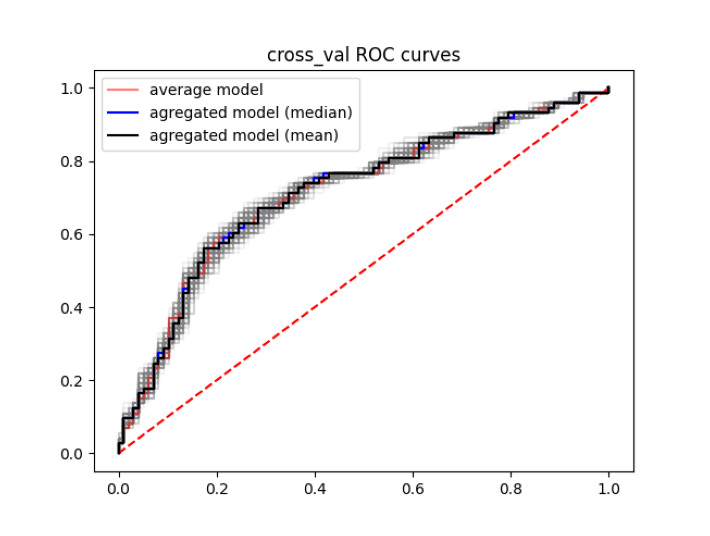

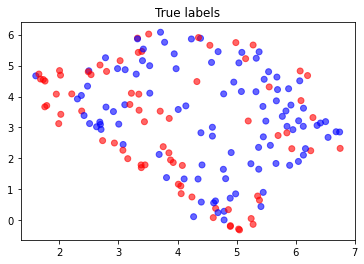

TypeError: '<=' not supported between instances of 'int' and 'numpy.ndarray'

<Figure size 10598.4x1036.8 with 0 Axes>

In [62]:
# test model
visual_embs = full_visualization(test_model)

# Visualize each variable of the latent

x, full_df and colors shapes:  (171, 10) (171, 11) (171, 10)
(10,) (10,) (10,)


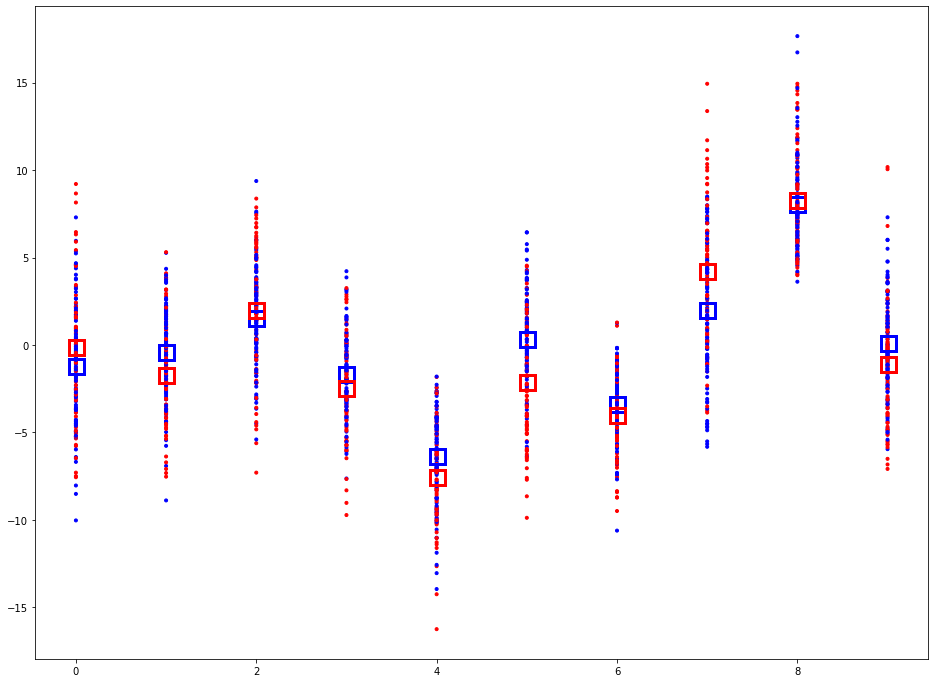

In [63]:
visualize_each_variable(test_model, display='all', display_err=False, normalize=False, verbose=False)

In [64]:
def do_pca(model_path, dataset='cingulate_ACCpatterns_1'):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Makes PCA over all dataframe
    latent_df = full_df.iloc[:,1:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = latent_df.shape[1]
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(latent_df_normalized)

    # Transforms over label0 dataframe
    label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
    label0_df = (label0_df - latent_df.mean()) / latent_df.std()
    transformed0 = pca.transform(label0_df)
    mean0 = np.mean(transformed0, axis=0)
    print(mean0.shape)

    # Transforms over label1 dataframe
    label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
    label1_df = (label1_df - latent_df.mean()) / latent_df.std()
    transformed1 = pca.transform(label1_df)
    mean1 = np.mean(transformed1, axis=0)
    print(mean1.shape)

    idx = np.arange(n_components)+1
    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T

    limit_df = n_components

    #make scree plot
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    fig, axs = plt.subplots(1, 2, figsize=(30,10)) 
    [t.set_color('white') for t in axs[0].xaxis.get_ticklabels()]
    [t.set_color('white') for t in axs[0].yaxis.get_ticklabels()]
    axs[0].set_title('Explained variance across principal components', fontsize=14)
    axs[0].set_xlabel('Principal component', fontsize=12)
    axs[0].set_ylabel('Explained variance', fontsize=12)
    sns.barplot(ax=axs[0], x=idx[:limit_df], y='explained variance', data=df_explained_variance, palette='summer')
    axs[0] = axs[0].twinx()
    axs[0].grid(False)
    axs[0].set_ylabel('Cumulative', fontsize=14)
    sns.lineplot(ax=axs[0], x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance, color='#fc8d59')

    N, D = transformed.shape
    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs[1].scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs[1].scatter(x, transformed1, c='red', marker='.')
    x = np.arange(D)
    axs[1].plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)
    axs[1].plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()


In [90]:
def do_dictionary_learning(model_path, dataset='cingulate_ACCpatterns_1', n_components=10):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Makes PCA over all dataframe
    latent_df = full_df.iloc[:,1:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = n_components
    dict_learner = DictionaryLearning(n_components=n_components, alpha=1)
    transformed = dict_learner.fit_transform(latent_df_normalized)

    # Transforms over label0 dataframe
    label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
    label0_df = (label0_df - latent_df.mean()) / latent_df.std()
    transformed0 = dict_learner.transform(label0_df)

    # Transforms over label1 dataframe
    label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
    label1_df = (label1_df - latent_df.mean()) / latent_df.std()
    transformed1 = dict_learner.transform(label1_df)

    fig, axs = plt.subplots(1, 1, figsize=(15,10)) 

    _, D = transformed0.shape

    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs.scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs.scatter(x, transformed1, c='red', marker='.')

    x = np.arange(D)

    masked0 = np.ma.masked_equal(transformed0, 0.)
    mean0 = masked0.mean(axis=0)
    axs.plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    masked1 = np.ma.masked_equal(transformed1, 0.)
    mean1 = masked1.mean(axis=0)
    axs.plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()

    return transformed0, transformed1, transformed, latent_df_normalized.values, dict_learner


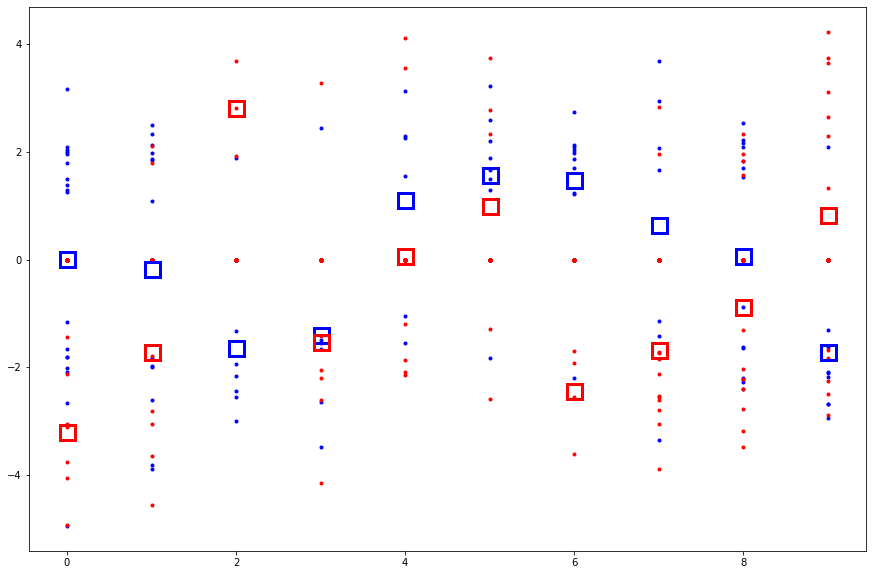

In [91]:
transformed0, transformed1, transformed, X, dict_learner = do_dictionary_learning(test_model, n_components=10)

In [88]:
print(f"sparsity = {np.mean(transformed == 0)}")
X_hat = transformed @ dict_learner.components_
print(f"reconstruction error = {np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1))}")

sparsity = 0.9
reconstruction error = 0.422112834751405


In [89]:
transformed[0]

array([-5.80596784,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [68]:
data_df = pd.read_csv(test_model+'/cingulate_ACCpatterns_1_embeddings/full_embeddings.csv', index_col=0)
data_df.sort_index(inplace=True)

print(transformed.shape)
print(data_df.head().iloc[:,0:5])

(171, 2)
                   dim1      dim2      dim3      dim4       dim5
ID                                                              
1-20FORHU_t0 -10.032169 -3.696359 -2.825965 -7.632609 -13.957271
1-23CREES_t0   5.362414 -8.888778 -0.878337  0.509884  -7.292371
2-02FERMA_t0  -2.593996  5.271532  3.332766  0.051636  -4.918207
2-04HEBTO_t0  -0.972216 -3.694903 -0.303646 -1.232962 -10.010797
2-08BESAG_t0  -1.749756 -4.978335  1.312038 -3.429286  -7.275100


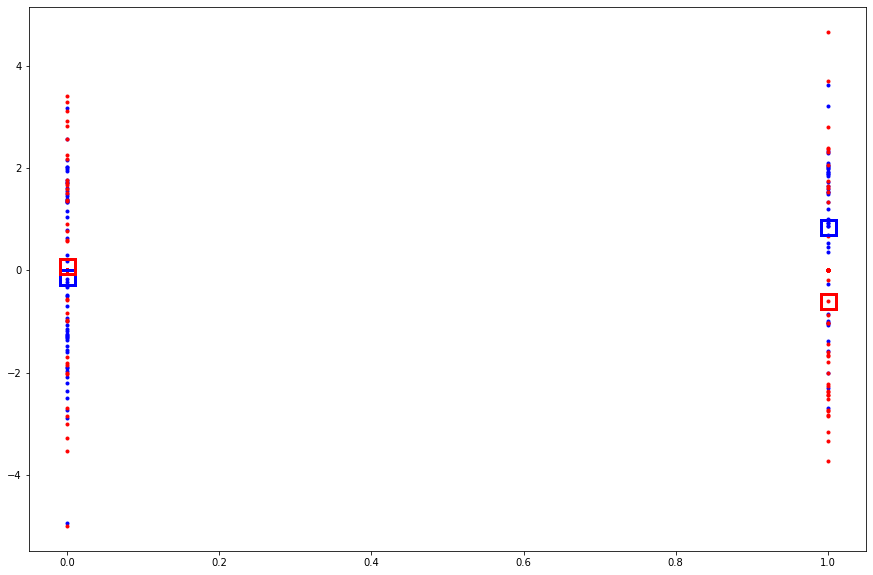

In [69]:
fig, axs = plt.subplots(1, 1, figsize=(15,10)) 

_, D = transformed0.shape

x = np.reshape(np.arange(D), (1,D))
x = np.repeat(x, transformed0.shape[0], axis=0)
axs.scatter(x, transformed0, c='blue', marker='.')
x = np.reshape(np.arange(D), (1,D))
x = np.repeat(x, transformed1.shape[0], axis=0)
axs.scatter(x, transformed1, c='red', marker='.')

x = np.arange(D)

masked0 = np.ma.masked_equal(transformed0, 0.)
mean0 = masked0.mean(axis=0)
axs.plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

masked1 = np.ma.masked_equal(transformed1, 0.)
mean1 = masked1.mean(axis=0)
axs.plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

plt.show()


(10,)
(10,)


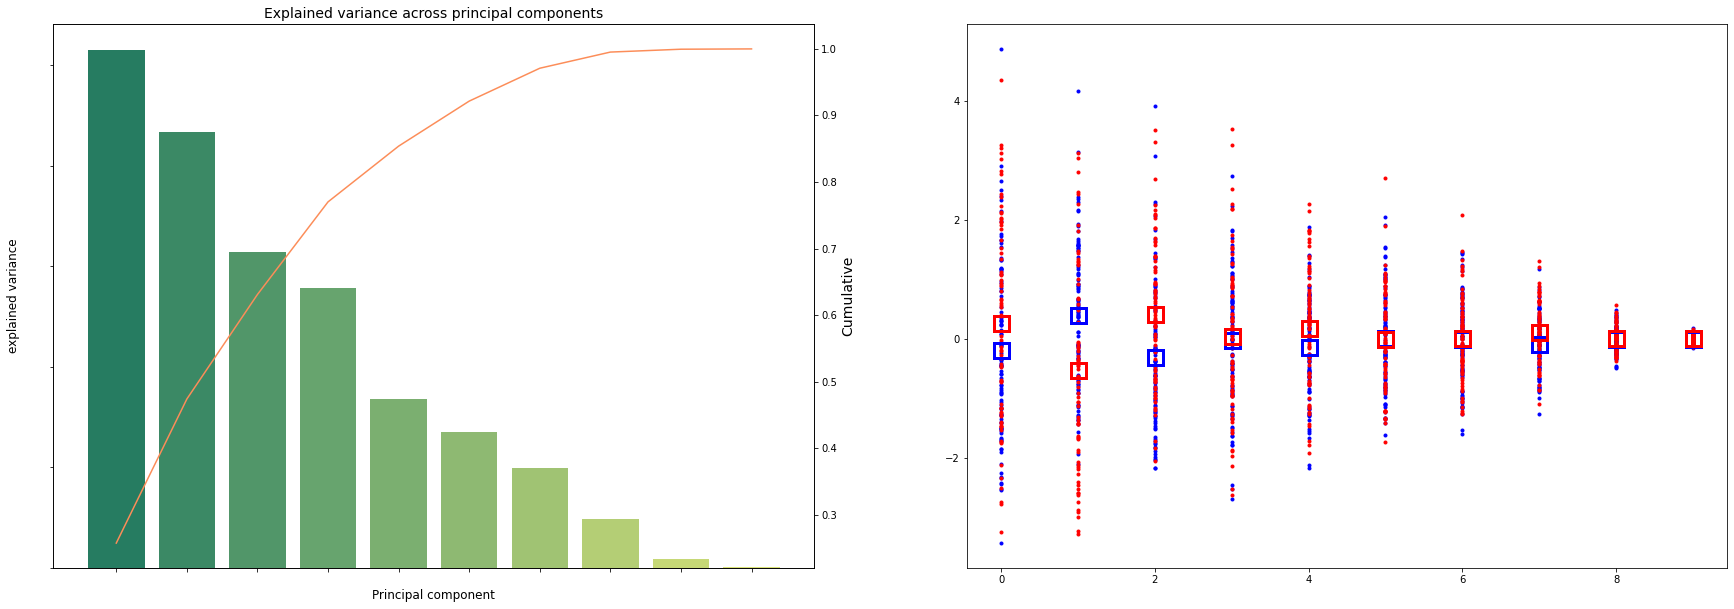

In [70]:
do_pca(test_model)

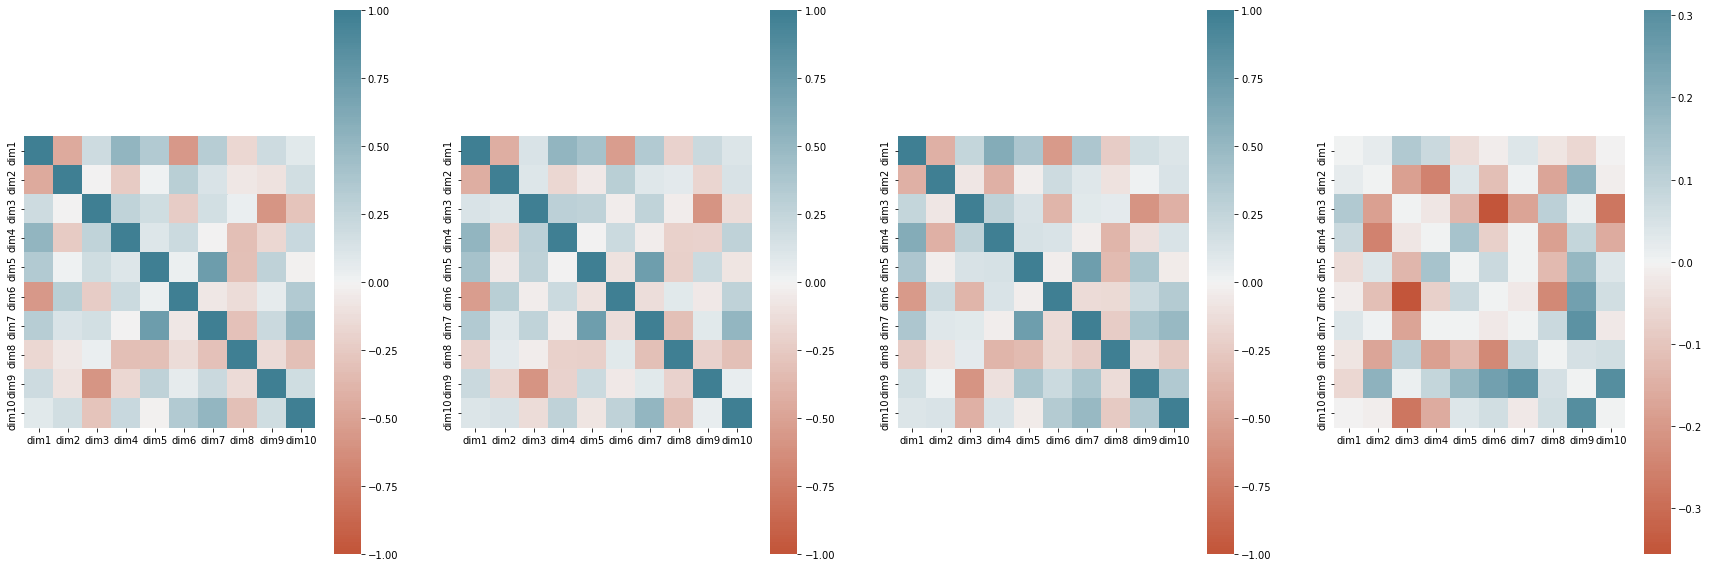

In [71]:
cross_correlation(test_model)